<a target="_blank" href="https://colab.research.google.com/github/felixp8/text-to-nn/blob/main/experiments/mlp/classifier/classifier.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [92]:
!pip install lightning

In [2]:
!git clone https://github.com/felixp8/text-to-nn.git

Cloning into 'text-to-nn'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 132 (delta 9), reused 6 (delta 2), pack-reused 106
Receiving objects: 100% (132/132), 46.43 MiB | 25.42 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [3]:
import os

os.chdir("./text-to-nn/experiments/mlp/data_generation")

In [21]:
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import h5py

In [5]:
from expr_utils import map_inputs, clean_expr

In [78]:
expression_file = "./data/simple/expressions.csv"
parameter_file = "./data/simple/parameters.h5"

expr_csv = pd.read_csv(expression_file)
with h5py.File(parameter_file, 'r') as h5f:
    parameters = h5f['nn_parameters'][:h5f['counter'][()].item(), :]

assert expr_csv.shape[0] == parameters.shape[0]

In [79]:
mult_mask = np.array(['*' in expr for expr in expr_csv['expr']])

expr_csv = expr_csv[~mult_mask]
parameters = parameters[~mult_mask]

In [80]:
expr_list = expr_csv['expr']
expr_list = [map_inputs(expr, 3, ['x', 'y', 'z']) for expr in expr_list]
expr_list = [clean_expr(expr) for expr in expr_list]
expr_list = [str(sp.parsing.sympy_parser.parse_expr(expr, evaluate=False)) for expr in expr_list]

In [81]:
le = LabelEncoder()
classes = le.fit_transform(expr_list)
num_classes = len(np.unique(classes))

In [26]:
# ss = StandardScaler()
# parameters_scaled = ss.fit_transform(parameters)

162
164


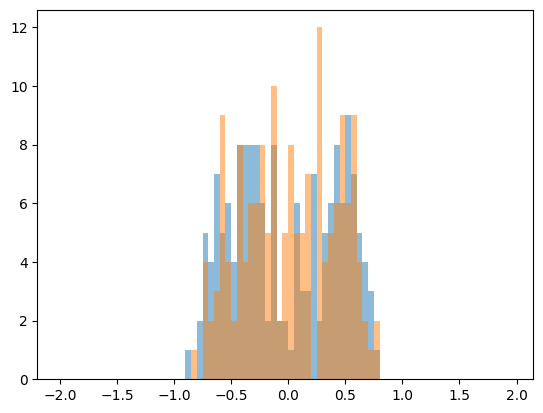

In [91]:
for i in range(2):
    mask = classes == i
    plt.hist(parameters[mask][:, 0], bins=np.arange(-2., 2., 0.05), alpha=0.5)
    print(mask.sum())

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [10]:
from model import MLP

In [83]:
inputs = torch.from_numpy(parameters)
targets = torch.from_numpy(classes)

dataset = torch.utils.data.TensorDataset(inputs, targets)
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [0.7, 0.3])

num_train = len(train_dataset)
num_valid = len(valid_dataset)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=512)

In [86]:
num_epochs = 100
lr = 1e-3
device = 'cpu'
log_every_n_epochs = 5

model = MLP(
    input_dim=353,
    hidden_dims=[256, 128,],
    output_dim=num_classes,
    activation='relu',
    dropout=0.5,
)

model = model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
for n in range(num_epochs):
    mean_train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = F.cross_entropy(y_pred, y)
        loss.backward()
        optimizer.step()
        mean_train_loss += loss.item() * x.shape[0] / num_train
    if (n % log_every_n_epochs == 0) or (n == num_epochs - 1):
        mean_valid_loss = 0
        for batch in valid_dataloader:
            with torch.no_grad():
                x, y = batch
                x = x.to(device)
                y = y.to(device)
                y_pred = model(x)
                loss = F.cross_entropy(y_pred, y)
                mean_valid_loss += loss.item() * x.shape[0] / num_valid
        print(f"Epoch {n:04d}: train loss = {mean_train_loss}, valid loss = {mean_valid_loss}")

Epoch 0000: train loss = 3.326159643845486, valid loss = 3.307714401542461
Epoch 0005: train loss = 3.0716332030771802, valid loss = 3.1114367369009965
Epoch 0010: train loss = 3.0266500448957423, valid loss = 3.090796494211987
Epoch 0015: train loss = 2.994181618246064, valid loss = 3.0866130477122025
Epoch 0020: train loss = 2.9438297357508745, valid loss = 3.0917191868045935
Epoch 0025: train loss = 2.8896926168411494, valid loss = 3.09395265851184
Epoch 0030: train loss = 2.8302700676760826, valid loss = 3.1083021064221636
Epoch 0035: train loss = 2.7635698266081756, valid loss = 3.1314776659918375
Epoch 0040: train loss = 2.71993668320997, valid loss = 3.131118056438722
Epoch 0045: train loss = 2.6660867105133903, valid loss = 3.1521836351532446
Epoch 0050: train loss = 2.6248839407079725, valid loss = 3.146607985514652
Epoch 0055: train loss = 2.538401130548958, valid loss = 3.1513247517125236
Epoch 0060: train loss = 2.5089989780748962, valid loss = 3.1073528170132363
Epoch 0065